### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Image Mosaicking #

#### Ananth Sridhar (ananth.sridhar@wisc.edu), Rangapriya Parthasarathy (rparthasarat@wisc.edu), Song Mei (smei4@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Pixel Absolute Difference](#2.A.-Pixel-absolute-difference)
  1. [Mean Absolute Difference](#2.B.-Mean-absolute-difference)
  1. [Mode Absolute Difference](#2.C.-Mode-absolute-difference)
  1. [Histogram based Matching](#2.D.-Histogram-based-matching)
1. [Solution](#3.-Solution)
  1. [Common Functions](#3.A.-Common-functions)
  1. [Load Images](#3.B.-Load-images)
  1. [Optimization Function](#3.C.-Optimization-function)
  1. [Mosaicking First Image](#3.D.-Mosaicking-first-image)
  1. [More Complicated Image with Image Library](#3.E.-More-complicated-image-with-image-library)
    1. [Brute Force Optimization](#3.E.a.-Brute-force-optimization)
    1. [Split RGB Channel](#3.E.b.-Split-RGB-channel)
    1. [Histogram based Matching](#3.E.c.-Histogram-based-Matching)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)
1. [Bonus: Create Your Own Mosaicking Image](#6.-Bonus:-create-your-own-mosaicking-image)

## 1. Introduction ##

Mosaicking is an old art technique where pictures or designs are formed by inlaying small bits of colored stone, glass, or tile. These small bits are visible close up, but the boundaries of the bits will blend and a single recognizable image will show at a distance. 

In the modern digital world, this acient art form has been transformed and combined with new technologies. As one has access to large public image database, individual images, instead of pure-colored blocks can be used as tiles to make pictures. Here is a famous mosaic image of president Obama made by [Anne Savage](http://news.siu.edu/2009/01/011509amh9004.php) during his campaign.
![Obama](http://news.siu.edu/_assets/images/2009/01/asavage_mosaic.jpg)
Nearly 6,000 images of individual faces are used to create this image. Sure enough, it has become a very popular poster because of the special art form. Using image mosaicking to form various pictures is very cool and seems like a daunting task because we are picking and arranging thousands of pictures from a even bigger pool of pictures. There are businesses helping you create your own mosaic work with charge. However, with intuition and just a little knowledge of optimization, we can do it at home ourselves!

We know images consist of pixels, and each pixel can be described using RGB color intensities. In order for two images to look alike, we just need to match their pixels. In this case, for the image to show at a distance, intuitively, we can just treat the basis images as "super pixels" and try to match them with the corresponding subimage of the target image. Naturally, we will take the target image and partition it into a grid whose size is our tile size. Then for each grid, we will choose one image from the basis that resembles the most. The way to qualify "resemblance" is discussed in detail in Part II. Because each chosen basis image resembles the grid best, after processing all grids, we will end up with a mosaicking image that overall best resembles the whole image. Notice that this is the most intuitive way to solve the problem, and it will always achieve the best result. We will present the solution using this method in the first section of Part III. This brute force method is limited by its speed; variants of the algorithm that speeds the process up will be discussed. We will also explore how changing the size of the tiles will affect the performance. The image basis in this project are obtained from online source [mazaika](http://www.mazaika.com/mazdownload.html).

## 2. Mathematical model ##

From the introduction above, it is clear that image mosaicking is an **assignment problem** which can be modeled as a **Mixed Integer Problem**. The **decision variables** $G_i,i\in\mathbf{I}$ ($\mathbf{I}$ is the set of all grids in target image) are which image (represented by its index $j\in\mathbf{B}$, where $\mathbf{B}$ is the set of basis images of size $s$) to choose for each grid $i$ of the target image. Therefore, $\mathbf{B}$ represent the restricted set of values $G_i$ can take. In the mathematical formulation, additional binary variable for each basis image is introduced to indicate whether this image is chosen for the grid. All these variables satisfy the **SOS constraint**. The **objective** is to minimize the difference$^*$ between the chosen mosaic and the target image. Note the difference function should be linear for the model to be MIP. ($^*$ _Several non-linear functions can be used to describe the resemblance of the grid and the basis image and be implemented within special algorithms. But they fall out of the scope of this course and are not discussed here._)

It is worth pointing out that in the current formulation, the optimization of each grid is independent from one another. Therefore, we can lessen the solvers burden by forming a model that solves the sub-problem of optimizing each grid. To optimize the whole target image, one can simply put the model in a function and call it for each grid of the image. For grid size $m\times n$, target grid can be represented by $m\times n\times 3$ RGB matrix $G$. Before optimization, basis images are pre-processed so that they all have the same size as the grid. Each basis image is represented as $m\times n\times 3$ RGB matrix $B_j,j\in\mathbf{B}$. The difference matrix ($m\times n\times 3$) between target $G$ and candidate $B_j$ is $D_j=G-B_j$.

In this project, we have limited the grid sizes to $2^p\times 2^p,~p\in\{0,1,\ldots,6\}$ square grids for the sake of scaling the basis. Further, we make sure the target image can be divided perfectly into integer number of grids. We have explored several differnt cost functions, and the formulation of each is described below.

### 2.A. Pixel absolute difference
$\text{minimize}:\qquad\sum_{x=1}^m\sum_{y=1}^n\sum_{c=R,G,B}~~error_{xy,c}$

$\text{subject to}:\qquad error_{xy,c}\geq E[x,y,c]$

$\qquad\qquad\qquad error_{xy,c}\geq -E[x,y,c]$

$\qquad\qquad\qquad E[x,y,c]=\sum_{j=1}^{s}D_j[x,y,c]\cdot p_j$

$\qquad\qquad\qquad \sum_{j=1}^s p_j=1, p_j\in\{0,1\}$

### 2.B. Mean absolute difference
$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nG[x,y,c]-\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nB_j[x,y,c],c\in\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1, p_j\in\{0,1\}$

### 2.C. Mode absolute difference
$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=mode(G[:,:,c])-mode(B_j[:,:,c]),c=\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1,p_j\in\{0,1\}$

The first formulation is the most straight forward yet most expensive way. The number of varibles and constraints scales with the size of the target image. Further, by trying to match individual pixels, one may not necessarily get the best performance because mosaicking is more about overall resemblance at a distance. As a result, the optimization model using this objective fuction is not shown in the solution part.

Considering matching individual pixels is very expensive and all we care about is the images look close at a distance. It is straight forward to treat each basis image as a whole. We can extract features from the picture. Two most frequently used are the mean (average) of the pixel RGB intensities and the mode (most frequent value) of the pixel RGB. Both of these are implemented.

### 2.D. Histogram based matching
$\text{mazimize}:\qquad\sum_{c=R,G,B}~~Correlation_{c} $

$\text{subject to}:\qquad Correlation[c]=\sum_{j=1}^{s}D_j[G,B_j]\cdot p_j$

$\qquad D_j[G,B_j]=\dfrac{\sum_{j=1}^{s}~~\Big[\Big(Hist(G[:,:,c])-Mean{(Hist(G[:,:,c])}\Big)\Big(Hist(B_j[:,:,c])-Mean{(Hist(B_j[:,:,c])}\Big)\Big]}{\sqrt{\sum_{}~~(Hist(G[:,:,c])-Mean{(Hist(G[:,:,c])))^2}}\sqrt{\sum_{j=1}^{s}~~(Hist(B_j[:,:,c])-Mean{(Hist(B_j[:,:,c])))^2}}},c=\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1,p_j\in\{0,1\}$

Histograms helps us capture an overall sense of the lightness and darkness and the amount of contrast of the image. In an image, I, I(x,y) represents the intensity at pixel with coordinates (x,y). The histogram h, as h(i) indicates that intensity i, appears h(i) times in the image. Mathematically, 
$\qquad\qquad\qquad\qquad\qquad h(i)=\sum_{x}\sum{y}~~I(x,y)=i$


We have also utilized histograms to compare each basis image $B_j$ with target grid $G$. This would essentially boil down to comparing two arrays of data. We have used correlation as the comparison metric for comparing the two arrays. **Correlation** is given by, 

$\qquad\qquad\qquad d(H_1,H_2)=\dfrac{\sum_{k}^{s}~~\Big[\Big(H1(k))-\overline{H1}\Big)\Big(H2(k))-\overline{H2}\Big)\Big]}{\sqrt{\sum_{k}~~\Big(H1(k))-\overline{H1}\Big)^2}\sqrt{\sum_{k}~~\Big(H2(k))-\overline{H2}\Big)^2}},\overline{H_i}=\dfrac{1}{N}\sum_{k=1}^{N} ~~H_i(k)$

Larger the distance metric, better the match. Perfect match would be $d(H_1,H_2)=1$. 

Therefore, the objective function in our problem is to maximize the correlation between the histograms of the target grid $G$ and the basis image $B_j$. This can be done both using the grayscale image and an RGB image. In the case of a grayscale image, the grayscale histograms of $G$ and $B_j$ are compared and in the case of an RGB image, the votes obtained for each intensity in each channel is summed in both $G$ adn $B_j$ and then the correlation between the corresponding two arrays of data is maximized. Both these cases are implemented.

## 3. Solution ##
### 3.A. Common functions
The following module contains all the helper functions to process the images. Run this section first before moving on to the optimization model.

In [2]:
using Images, DataFrames, FixedPointNumbers, PyPlot, Colors, ProgressMeter

# loads all jpg image files inside the directory
function get_image_files(image_dir)
    # get all the files in the directory
    dir_contents = readdir(image_dir)
    dir_contents = [ join([image_dir, dir_contents[i]], "/") for i in 1:length(dir_contents) ]
    
    # retain only jpg image files
    image_files = filter(x->ismatch(r"(.jpg$)|(.jpeg$)"i, x), dir_contents)
    
    # return the paths to the jpg image files
    return image_files
end

# converts image to a h x w matrix
#   h = height
#   w = width
function convert_image_to_mat(image)
    image_mat = reinterpret(UInt8, separate(image).data)
    return image_mat
end

# converts a h x w matrix to an Images module image
function convert_mat_to_image(image_mat)
    image = colorim(image_mat)
    return image
end

# load a list of image files as a cell array of image matrices
function load_images_as_cellarray_mats(image_files)
    images_mat = cell(length(image_files),1)
    for (image_n, image_file) in enumerate(image_files)
        image = load(image_file)
        image_mat = convert_image_to_mat(image)
        
        # fix for RGB4 seen on Mac because of ImageMagick behavior
        #  read only RGB (ignore the 4th value)
        image_mat = image_mat[:,:,1:3]
        
        images_mat[image_n] = image_mat
    end
    return images_mat
end

# convert a cell array of image matrices to a cell array of images
function load_cellarray_mats_as_images(images_mat)
    images = cell(length(images_mat),1)
    for (image_n, image_mat) in enumerate(images_mat)
        image = convert_mat_to_image(image_mat)
        images[image_n] = image
    end
    return images
end

# silly way to make all images the same size
function subsample_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = image[1:desired_size[2], 1:desired_size[1], :]
    end
    return images_mat
end

# scale an image (fixed size 64x64) to the desired size
function scale_image(image,desired_size)
    n_combine = floor( size(image, 1)/desired_size[1])
    n_pixel = n_combine*n_combine
    temp=image[1:desired_size[2], 1:desired_size[1], :]
    for i in 1:desired_size[2]
        for j in 1:desired_size[1]
            sub = image[(i-1)*n_combine+(1:n_combine),(j-1)*n_combine+(1:n_combine),:]
            for c in 1:3
                pixel=convert(UInt8,round(sum(sum(sub[:,:,c]))/n_pixel))
                temp[i,j,c]=pixel
            end
        end
    end
    return temp
end

# scale a list of images to the desired size
function scale_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
            images_mat[image_n] = scale_image(image,desired_size)
    end
    return images_mat
end

; # suppress output

    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /home/juser/.julia/v0.4/DataArrays/src/broadcast.jl:330
is ambiguous with: 
    .>(Images.AbstractImageDirect, AbstractArray) at /home/juser/.julia/v0.4/Images/src/algorithms.jl:179.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}})
before the new definition.
    .>(AbstractArray, Union{DataArrays.PooledDataArray, DataArrays.DataArray}) at /home/juser/.julia/v0.4/DataArrays/src/broadcast.jl:285
is ambiguous with: 
    .>(Images.AbstractImageDirect, AbstractArray) at /home/juser/.julia/v0.4/Images/src/algorithms.jl:179.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.PooledDataArray, DataArrays.DataArray})
before the new definition.
    +(AbstractArray, DataArrays.DataArray) at /home/juser/.julia/v0.4/DataArrays/src/operato

### 3.B. Load images
This section contains the sample preparation work before mosaicking image. Loading the test images, loading the basis images, and scaling the basis images to the desired size. These will be copied and properly modified in following sections when we do different mosaickings.

In [4]:
# load target images
test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded")

test_image = test_images_mat[1]

#**************************************
# library with 4 gray scale images
#**************************************
image_files = get_image_files("./grayscale") 

#**************************************
# library with images
#**************************************
# image_files = get_image_files("./music0500")
# image_files = get_image_files("./music1000")
# image_files = get_image_files("./music1500")

# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 16
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

; # to suppress display

1 test image files loaded
4 basis image files loaded


### 3.C. Optimization function
The optimization of a single grid put in a function.

In [27]:
using JuMP, Mosek
function pickOpt(sub_test_image,optimize_color)
    m = Model(solver = MosekSolver(LOG=1))
    @defVar(m, pick_basis[1:n_basis], Bin)
    @defVar(m, AbsMatchError[1:n_colors] >= 0)
        
    @addConstraint(m, sum(pick_basis) == 1)
        
    test_image_value = nothing
    if optimize_color
        test_image_value = [ mode(sub_test_image[:,:,color]) for color in 1:n_colors ]
    else
        test_image_value = [ mean(sub_test_image[:,:,color]) for color in 1:n_colors ]
    end
        
    @defExpr(m, MatchError[color in 1:n_colors], test_image_value[color] - sum(dot(pick_basis,basis_colors[:,color])) )
    @addConstraint(m, MatchError .<=  AbsMatchError)
    @addConstraint(m, MatchError .>= -AbsMatchError)
        
    @setObjective(m, Min, sum(AbsMatchError))
        
    status = solve(m)
    # show some output to communicate that things are moving forward
    opt_pick_basis = getValue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

### 3.D. Mosaicking first image
Try mosaicking our first image. Target is a black and white QR code image, and we choose the gray scale image set. Should be able to get the exact picture back with small enough basis images.

4 basis image files loaded
Progress: 100% Time: 0:00:21


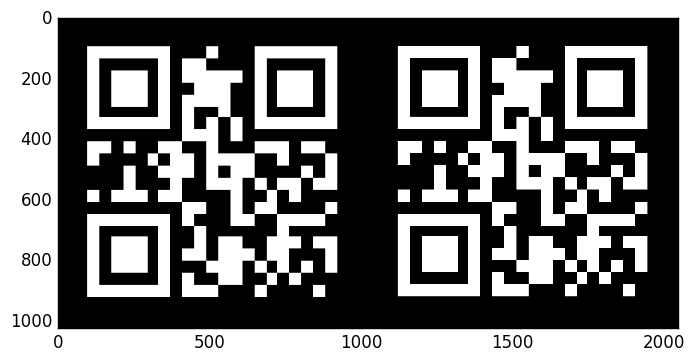

In [14]:
# load target images
test_image = test_images_mat[1]

# use gray scale
image_files = get_image_files("./grayscale") 

# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 8
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

optimize_color = true
basis_colors = nothing
n_colors = nothing
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick out the target grid
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        if optimize_color
            n_colors = 3
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                end
            end
        else
            n_colors = 1
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                end
            end
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
        basis_choice[j,i] = chosen_basis
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

# plot two images side by side to see how we did
imshow([test_image mosaic_image]);

### 3.E. More complicated image with image library
In this section, we are optimizing a real image with one of our libraries. We first solve the problem using the brute force way. Then several improvement are explored. Here is the image we are mosaicking.

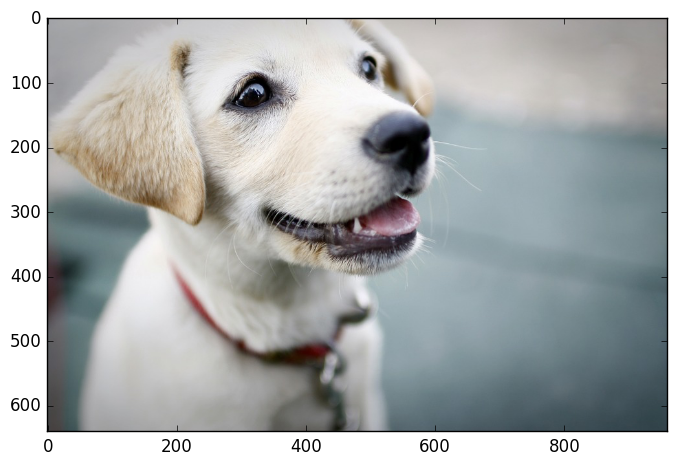

In [19]:
test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)
imshow(test_images_mat[2]);

#### 3.E.a. Brute force optimization
The brute force way means we do the optimization for each grid the same way using the function in section [3.C.](#3.C.-Optimization-function) without any prior processing. The following section loads the basis and rescale it to the desired size.

In [28]:
image_files = get_image_files("./music0500")
# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 8
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded");

498 basis image files loaded


498 basis image files loaded
Progress: 100% Time: 0:27:07


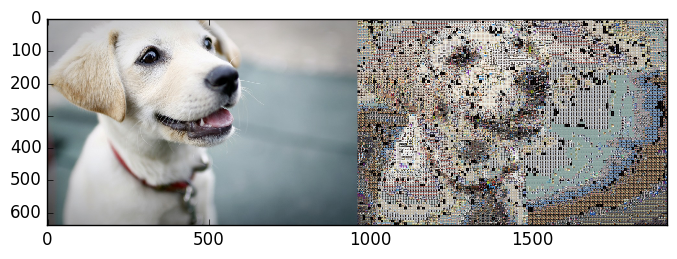

In [17]:
# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

# set running parameters
optimize_color = true
basis_colors = nothing
n_colors = nothing
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick out the target grid
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        if optimize_color
            n_colors = 3
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                end
            end
        else
            n_colors = 1
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                end
            end
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
        basis_choice[j,i] = chosen_basis
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

# plot two images side by side to see how we did
imshow([test_image mosaic_image]);

#### 3.E.b. Split RGB channel
Notice the brute force way is very slow because the SOS constraint has the size of the whole basis array for each sub-problem. Further, the result is not very satisfying at some points. It is worth noting that smallest $L_1$ norm does not necessarily guarantee similar color appearance. For example at the lower right corner, the brownish basis is chosen for the dark blue regions. To address this, we can preprocess both the grid and basis images by identifying the dominate color. The simple way is to find the color with the largest average intensity. By doing this, we roughly reduces the basis size for each sub-problem to $\frac{1}{3}$ of the original basis size. Additionally, we guarantee the basis image we choose for each grid has the same dominant color as the grid itself.

Two additional helper functions are used for this method, run them before the optimization.

In [43]:
# Additional helper functions

# find the dominant channel for an image
function find_channel(image)
    ch = 0    
    max = -1
    avgc = 0
    for c in 1:3
        avgc = mean(image[:,:,c])
        if (avgc > max)
        max = avgc
        ch = c
        end
    end
    return ch
end

# split the basis image array to 3 different basis sets based on the dominant channel
function split_channel(images_mat,images_r,images_g,images_b)
    cnt = zeros(3)
    for (image_n, image) in enumerate(images_mat)
        c=find_channel(image)
        cnt[c] = cnt[c]+1
        if (c==1)
            images_r[cnt[c]]=copy(image)
        elseif (c==2)
            images_g[cnt[c]]=copy(image)
        else
            images_b[cnt[c]]=copy(image)
        end
    end
    return cnt
end
;

##### Split the basis image to 3 sets

In [46]:
images_r = similar(images_mat)
images_g = similar(images_mat)
images_b = similar(images_mat)
count=split_channel(images_mat,images_r,images_g,images_b)
images_r = images_r[1:count[1]]
images_g = images_g[1:count[2]]
images_b = images_b[1:count[3]];

##### Solve for splitted channels

Progress: 100% Time: 0:06:43


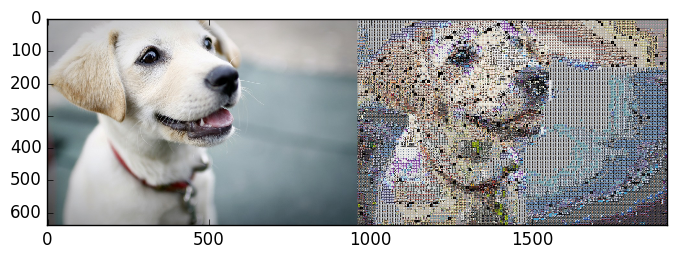

In [50]:
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

optimize_color = true
basis_colors = nothing
n_colors = nothing
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick out the target grid
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        # find the channel of the sub-image and choose the corresponding basis for optimization
        channel = find_channel(sub_test_image)
        if (channel == 1)
            images_base = images_r
        elseif (channel == 2)
            images_base = images_g
        else
            images_base = images_b
        end
        n_basis = size(images_base)[1]
        if optimize_color
            n_colors = 3
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mode(images_base[basis][:,:,color])
                end
            end
        else
            n_colors = 1
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mean(images_base[basis][:,:,:])
                end
            end
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
        basis_choice[j,i] = chosen_basis
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = copy(images_base[chosen_basis])
    end
end

# plot two images side by side to see how we did
imshow([test_image mosaic_image]);

####3.E.c. Histogram based Matching
Another method which was previously discussed was using Histogram matching to match the target grid with the best match from the basis set. This gives a smoother result compared to previous methods discussed above. The total number of bins used has not been quantized here. We have used 256 bins each for 0 - 255 intensities.Two more helper functions are added for this method. 

In [3]:
#Additional helper files
#Convert rgb image to grayscaled image
function rgb2gray(image_files)
    images_gray_mat = cell(length(image_files),1)
    for (image_n, image_file) in enumerate(image_files)
        image = load(image_file)
        image_gray = convert(Image{Gray{Ufixed8}}, image)
        image_mat = reinterpret(UInt8, separate(image_gray).data)
        image_gray_mat=rand(UInt8, size(image_mat,1), size(image_mat,2),3)
        image_gray_mat[:,:,1]= image_mat[:,:,1]
        image_gray_mat[:,:,2]= image_mat[:,:,1]
        image_gray_mat[:,:,3]= image_mat[:,:,1]      
        images_gray_mat[image_n] = image_gray_mat
    end
    return images_gray_mat
end

#Scale a grayscale image
function scale_gray_image(image,desired_size)
     n_combine = 64/desired_size[1]
    n_pixel = n_combine*n_combine
    temp=image[1:desired_size[2], 1:desired_size[1], :]
    for i in 1:desired_size[2]
        for j in 1:desired_size[1]
            sub = image[(i-1)*n_combine+(1:n_combine),(j-1)*n_combine+(1:n_combine),:]
            
            pixel=convert(UInt8,round(sum(sum(sub[:,:,1]))/n_pixel))
            temp[i,j,1]=pixel
            end
        end
    temp[:,:,2]=temp[:,:,1]
    temp[:,:,3]=temp[:,:,1]
    return temp
end

#Scale an array of grayscale images
function scale_cellarray_gray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = scale_gray_image(image,desired_size)
    end
    return images_mat
end

#Convert the image type to Int64 for easy calculation of image histogram
function convert_image_mat_to_Int64(image_mat)
    image_mat1=rand(Int64,size(image_mat,1),size(image_mat,2),size(image_mat,3))
    for i in 1:size(image_mat,1)
        for j in 1:size(image_mat,2)
            for k in 1:size(image_mat,3)
                image_mat1[i,j,k]=convert(Int64, image_mat[i,j,k])
            end
        end
    end
    
    return image_mat1
end

convert_image_mat_to_Int64 (generic function with 1 method)

#####Get dimensions


In [8]:
image_files = get_image_files("./Basis_1")
base_size = 8
images_mat = load_images_as_cellarray_mats(image_files)
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)
images_gray_mat=rgb2gray(image_files)

images_gray_mat = scale_cellarray_gray_mats(images_gray_mat, desired_size)
println(length(images_mat), " basis image files loaded")
test_image_files = get_image_files("./Test")
test_images_mat = load_images_as_cellarray_mats(test_image_files)
test_images_gray_mat=rgb2gray(test_image_files)

println(length(test_images_mat), " test image files loaded")

test_image = test_images_mat[1]
test_image_gray = test_images_gray_mat[1]
n_basis = length(images_mat)
w_basis = size(images_mat[1], 2)
h_basis = size(images_mat[1], 1)
w_test_image = size(test_image, 2)
h_test_image = size(test_image, 1)

n_basis_width = round(Int64, w_test_image/w_basis)
n_basis_height = round(Int64, h_test_image/h_basis);

498 basis image files loaded
1 test image files loaded


#####Optimization function

In [5]:
using JuMP, Mosek
corr = zeros(n_basis,1)
function pickOpt(sub_test_image,optimize_color)
    m = Model(solver = MosekSolver(LOG=1))
    @defVar(m, pick_basis[1:n_basis], Bin)
    @defVar(m, AbsMatchError[1:n_colors] >= 0)
    @defVar(m,test_image_hist_mean>=0)    
    @addConstraint(m, sum(pick_basis) == 1)
    if optimize_color #Calculate histogram for each channel and sum it
        (nothing,test_image_hist1) = hist(vec(sub_test_image[:,:,1]),-1:255)
        (nothing,test_image_hist2) = hist(vec(sub_test_image[:,:,2]),-1:255)
        (nothing,test_image_hist3) = hist(vec(sub_test_image[:,:,3]),-1:255)
        test_image_hist=test_image_hist1+test_image_hist2+test_image_hist3
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
    else
        (nothing,test_image_hist) = hist(vec(sub_test_image[:,:,1]),-1:255)
        test_image_hist_mean=test_image_hist - mean(test_image_hist)
    end
    
    for basis in 1:n_basis #Calculate correlation between tagret grid and each basis
        corr_num=(sum(test_image_hist_mean.*hist_basis_mat[basis]))
        corr[basis]=sum(corr_num/((sqrt(sum(test_image_hist_mean.^2))).*sqrt(sum(hist_basis_mat[basis].^2))));
    end
    
    #Check if value is NaN
    for basis in 1:n_basis
        if isequal(corr[basis],NaN)
            corr[basis]=0
        end
    end
    
    @defExpr(m, Correlation, sum(dot(pick_basis,corr[:])))
    @setObjective(m, Max, Correlation)
        
    status = solve(m)
    opt_pick_basis = getValue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

#####Run optimization function for each target grid

Progress: 100% Time: 0:03:32

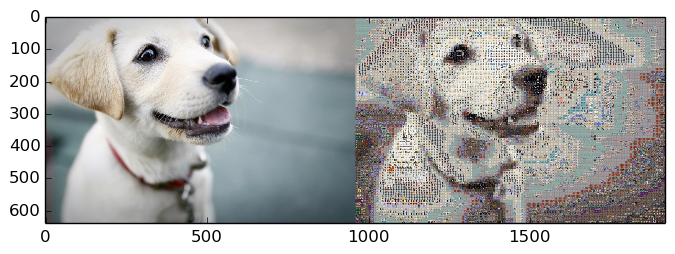

PyObject <matplotlib.image.AxesImage object at 0x7ff0ed374b50>

In [6]:
using Debug 
optimize_color = true
n_colors=1
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = copy(test_image)
hist_basis_mat = cell(n_basis,1)
hist_basis_mat1 = cell(n_basis,1)
hist_basis_mat2 = cell(n_basis,1)
hist_basis_mat3 = cell(n_basis,1)

test_image1=rand(Int64,size(test_image,1),size(test_image,2),size(test_image,3))
images_mat1 = cell(length(images_mat),1)
test_image_gray1=rand(Int64,size(test_image_gray,1),size(test_image_gray,2),size(test_image_gray,3))
images_gray_mat1 = cell(length(images_gray_mat),1)
for basis in 1:n_basis
    images_mat1[basis]=rand(Int64,size(images_mat[basis],1),size(images_mat[basis],2),size(images_mat[basis],3))
     
end
for basis in 1:n_basis
    images_gray_mat1[basis]=rand(Int64,size(images_gray_mat[basis],1),size(images_gray_mat[basis],2),size(images_gray_mat[basis],3))
end
test_image1 = convert_image_mat_to_Int64(test_image)
test_image_gray1=convert_image_mat_to_Int64(test_image_gray)
for basis in 1:n_basis
    images_mat1[basis]=convert_image_mat_to_Int64(images_mat[basis])
    images_gray_mat1[basis]=convert_image_mat_to_Int64(images_gray_mat[basis])
end
@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
       
       if optimize_color
            n_colors=3
             # pick out the target grid
            sub_test_image = test_image1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]
                for basis in 1:n_basis
                (a,hist_basis_mat1[basis]) = hist(vec(images_mat1[basis][:,:,1]),-1:255)
                (a,hist_basis_mat2[basis]) = hist(vec(images_mat1[basis][:,:,2]),-1:255)
                (a,hist_basis_mat3[basis]) = hist(vec(images_mat1[basis][:,:,3]),-1:255) 
                hist_basis_mat[basis]= hist_basis_mat1[basis]+hist_basis_mat2[basis]+hist_basis_mat3[basis]
                hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])
                end
            else 
            n_colors=1
             # pick out the target grid
            sub_test_image = test_image_gray1[(j-1)*h_basis+(1:h_basis),(i-1)*w_basis+(1:w_basis),:]  
            for basis in 1:n_basis
                (a,hist_basis_mat[basis]) = hist(vec(images_gray_mat1[basis]),-1:255) #Number of bins used in histogram =60
                hist_basis_mat[basis]=hist_basis_mat[basis]-mean(hist_basis_mat[basis])
                
            end  
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
         basis_choice[j,i] = chosen_basis
       
         if optimize_color
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
           
        else
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis),:] = images_gray_mat[chosen_basis]
        end      
        
    end
end
if optimize_color
     # plot two images side by side to see how we did
    imshow([test_image mosaic_image]);
else
    imshow([test_image_gray mosaic_image]);
end

####In the case of a grayscale image

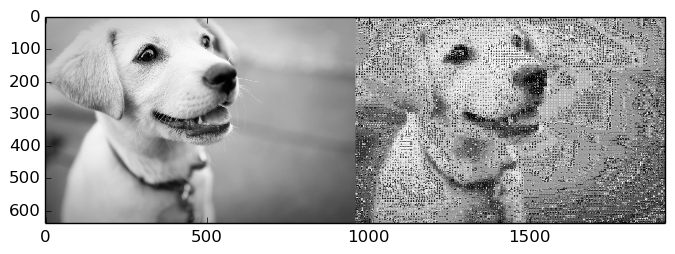

PyObject <matplotlib.image.AxesImage object at 0x7ff0ec93c190>

In [10]:
imshow([test_image_gray mosaic_image])

## 4. Results and discussion ##

#### 4.A. Comparison between 
Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

Use plots (see `PyPlot` and `Gadfly` examples from class), or you can display results in a table like this:

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned |\$1600 |
| col 2 is      | centered      |  \$12 |
| zebra stripes | are neat      |   \$1 |

### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.

## 6. Bonus: create your own mosaicking image ##

1. Put the image url down here.

Customer test image file loaded


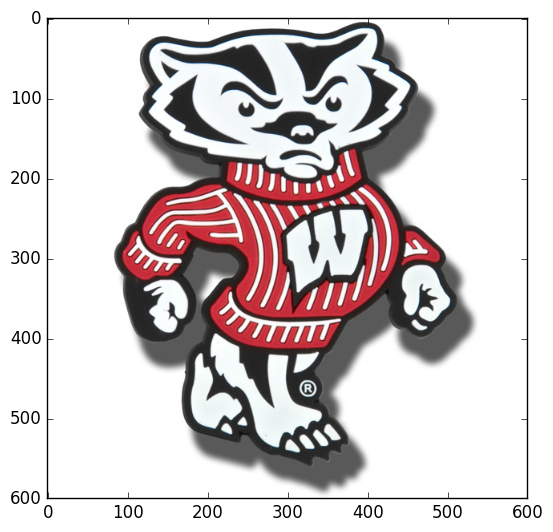

In [79]:
using HTTPClient

img = get("http://wallpaper.zone/img/2789695.jpg")
outfile = open("myimage.jpg", "w")
write(outfile, img.body.data)
close(outfile)
my_image_file = load("./myimage.jpg")
my_image_mat = convert_image_to_mat(my_image_file)
println("Customer test image file loaded")
imshow(my_image_mat);